(300,)


(array([ 3.,  2.,  6.,  9., 15., 17., 15., 19., 12., 16., 15., 31., 32.,
        40., 31., 24., 10.,  2.,  0.,  1.]),
 array([ 47.40688607,  58.916721  ,  70.42655594,  81.93639088,
         93.44622581, 104.95606075, 116.46589569, 127.97573062,
        139.48556556, 150.99540049, 162.50523543, 174.01507037,
        185.5249053 , 197.03474024, 208.54457518, 220.05441011,
        231.56424505, 243.07407999, 254.58391492, 266.09374986,
        277.60358479]),
 <a list of 1 Patch objects>)

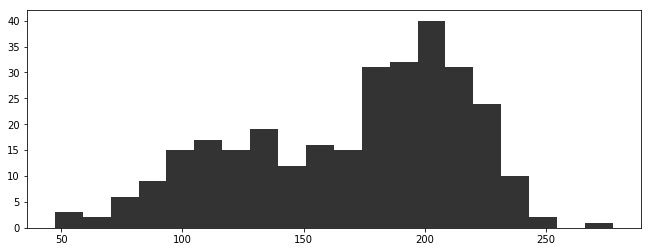

In [10]:
import pymc3 as pm
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("data/mixture_data.csv", delimiter=",")
print(data.shape)
plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)

In [2]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    val = np.random.randint(0, 2, data.shape[0])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=val)
    
print(type(p))
print(p1.tag.test_value, p2.tag.test_value)
print(p.tag.test_value)
print(assignment.tag.test_value, np.sum(assignment.tag.test_value), len(assignment.tag.test_value))

<class 'theano.tensor.var.TensorVariable'>
0.5 0.5
[0.5 0.5]
[1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0
 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0
 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0
 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0
 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0
 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0
 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1
 1 1 1 1] 158 300


In [3]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([100, 210]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)

In [4]:
print("Random assignments: ", assignment.tag.test_value[:20], "...")
print("Assigned center: ", center_i.tag.test_value[:20], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:20])

Random assignments:  [1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0] ...
Assigned center:  [210. 210. 100. 210. 210. 100. 100. 100. 210. 210. 100. 100. 210. 210.
 210. 100. 210. 100. 100. 100.] ...
Assigned standard deviation:  [50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50.]


In [5]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(2500, step=[step1, step2])

/Users/ctyl/.pyenv/versions/3.6.2/envs/PyMC-Learning/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_interval__]
>ElemwiseCategorical: [assignment]
100%|██████████| 3000/3000 [00:15<00:00, 190.53it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


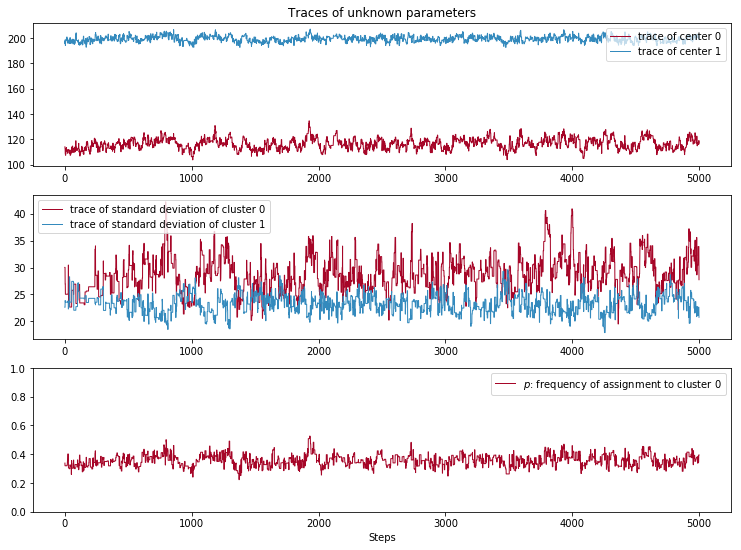

In [6]:
from IPython.core.pylabtools import figsize
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

In [7]:
with model:
    trace = pm.sample(5000, step=[step1, step2], trace=trace)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_interval__]
>ElemwiseCategorical: [assignment]
100%|██████████| 5500/5500 [00:34<00:00, 157.56it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


(12500, 2)
(2500, 2)


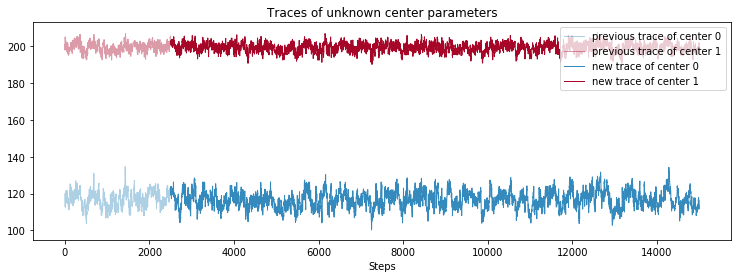

In [8]:
figsize(12.5, 4)
center_trace = trace["centers"][2500:]
print(center_trace.shape)
prev_center_trace = trace["centers"][:2500]
print(prev_center_trace.shape)
x = np.arange(2500)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(2500, 15000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

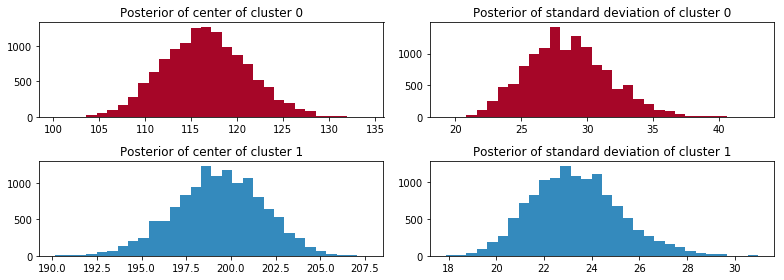

In [9]:
figsize(11.0, 4)
std_trace = trace["sds"][2500:]
prev_std_trace = trace["sds"][:2500]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()